In [ ]:
# STEP 1: Install Required Libraries
!pip install -q kaggle timm scikit-learn albumentations tqdm
!pip install -q torch torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 29.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 35.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 50.7 MB/s eta 0:00:00


In [ ]:
import joblib
import torch
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, f1_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn
import timm
from torch.utils.data import Dataset, DataLoader
from PIL import Image, UnidentifiedImageError  # <-- Add this import
from torchvision import transforms


In [ ]:
# STEP 2: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
# STEP 1: Load test dataset
test = joblib.load('/content/drive/MyDrive/PW2/test_dataset.pkl')

In [ ]:
# STEP 2: Dataset class definition (use the same as your original training script)
class ISICDatasetWithMeta(Dataset):
    def __init__(self, dataframe, transform=None):
        self.data = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        while True:
            img_path = self.data.iloc[idx]['image_path']
            try:
                image = Image.open(img_path).convert("RGB")
                if self.transform:
                    image = self.transform(image)
                sex = float(self.data.iloc[idx]['sex'])
                age = float(self.data.iloc[idx]['age_approx'])
                site = float(self.data.iloc[idx]['anatom_site_general'])
                meta_data = torch.tensor([sex, age, site], dtype=torch.float32)
                label = torch.tensor(self.data.iloc[idx]['target'], dtype=torch.float32)
                return image, meta_data, label
            except (FileNotFoundError, UnidentifiedImageError, OSError) as e:
                print(f"⚠️ Error loading file {img_path}: {e}. Skipping...")
                idx = (idx + 1) % len(self.data)

In [ ]:
# STEP 3: Test transformations
val_test_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

In [ ]:
# STEP 4: Test DataLoader
test_loader = DataLoader(ISICDatasetWithMeta(test, val_test_transforms), batch_size=32, shuffle=False)

In [ ]:
# STEP 5: Load Model class definition
class ResNeSt101Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.base_model = timm.create_model('resnest101e', pretrained=False, num_classes=0, global_pool='avg')
        self.meta_fc = nn.Sequential(
            nn.Linear(3, 32), nn.BatchNorm1d(32), nn.ReLU(), nn.Dropout(0.3)
        )
        self.head = nn.Sequential(
            nn.Linear(self.base_model.num_features + 32, 256),
            nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(256, 1)
        )

    def forward(self, x, meta):
        x = self.base_model(x)
        meta = self.meta_fc(meta)
        x = torch.cat([x, meta], dim=1)
        return self.head(x).squeeze()

In [ ]:
test_loader = DataLoader(ISICDatasetWithMeta(test, val_test_transforms), batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

In [ ]:
# STEP 6: Load the saved best F1 model
model_path = '/content/drive/MyDrive/PW2/models/ResNeSt101_BestModel_combined_improved.pth'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNeSt101Model().to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

ResNeSt101Model(
  (base_model): ResNet(
    (conv1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): ResNestBottleneck(
        (conv1): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, t


📊 Evaluation Metrics
ROC AUC       : 0.9839
Accuracy      : 0.9710
Recall        : 0.8912
Specificity   : 0.9835
F1 Score      : 0.8929


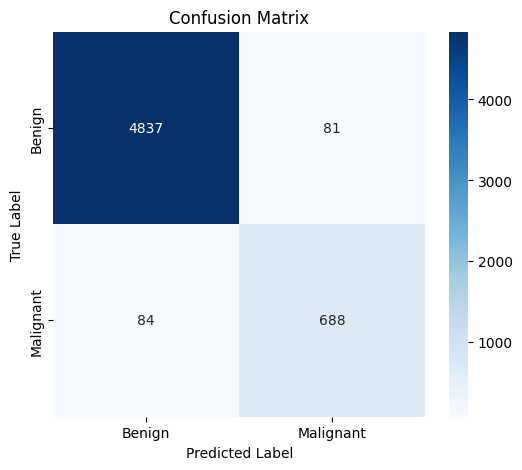

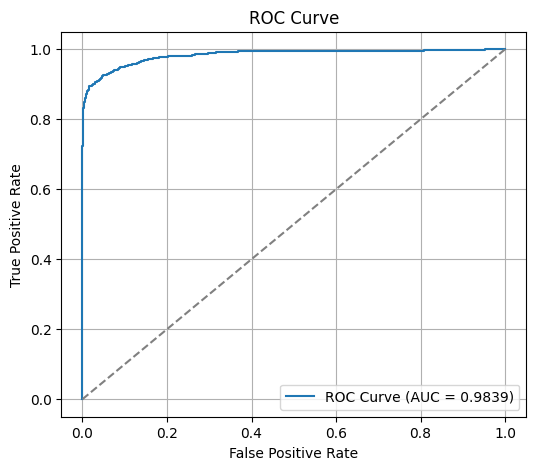

In [ ]:
# STEP 7: Evaluation
preds, labels, probs = [], [], []

with torch.no_grad():
    for images, meta, label in test_loader:
        images, meta = images.to(device), meta.to(device)
        output = torch.sigmoid(model(images, meta)).cpu().numpy()
        probs.extend(output)
        preds.extend((output > 0.5).astype(int))
        labels.extend(label.numpy())

# Metrics calculation
roc_auc = roc_auc_score(labels, probs)
accuracy = accuracy_score(labels, preds)
recall = recall_score(labels, preds)
f1 = f1_score(labels, preds)
cm = confusion_matrix(labels, preds)
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)

# STEP 8: Display metrics
print("\n📊 Evaluation Metrics")
print(f"ROC AUC       : {roc_auc:.4f}")
print(f"Accuracy      : {accuracy:.4f}")
print(f"Recall        : {recall:.4f}")
print(f"Specificity   : {specificity:.4f}")
print(f"F1 Score      : {f1:.4f}")

# STEP 9: Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# STEP 10: Plot ROC Curve
fpr, tpr, _ = roc_curve(labels, probs)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()